In [15]:
import pandas as pd
import polars as pl
import numpy as np
import sqlite3
import qrcode

import os

from id_generation.id_generation import generate_ids
from encryption.aes import encrypt_message, decrypt_message, generate_random_encryption_key

```mermaid
erDiagram
    Keys {
        string encrypted_id PK
        string encryption_key
        string uncrypted_id
        datetime date_added
    }
```

In [2]:
conn = sqlite3.connect("database.sqlite")
cur = conn.cursor()

In [3]:
cur.execute("DROP TABLE IF EXISTS keys;")

cur.execute("""
CREATE TABLE keys (
    encrypted_id TEXT PRIMARY KEY,
    encryption_key TEXT NOT NULL,
    unencrypted_id TEXT NOT NULL,
    date_added DATETIME DEFAULT CURRENT_TIMESTAMP
);""")

In [4]:
unencrypted_ids = generate_ids(quantity=2000)
data_insertion = []
for unencrypted_id in unencrypted_ids:
    encryption_key = generate_random_encryption_key()
    encrypted_id = encrypt_message(unencrypted_id, encryption_key)

    data_insertion.append((
        encrypted_id,
        encryption_key,
        unencrypted_id
    ))

data_insertion

[('WqTQp1+UNBSofucBHaml0v+Lyu4Ky4841Qh0guiNJzY=',
  b'y\xae\x8c9F\xb7\x97\x14\xcb\xc48&\x0b\xcf\xab\xd7\x0eB\xf4\x0cBM\x85\x1b\xf3\xcfO->u\xe9g',
  'MP_00001'),
 ('8vwxf58YJGRdUkbSRzndvrDE6xDYduvCDeTg6UjK44w=',
  b'T\x83\xeal\x8a\xd4Q\xf7\x0f\x17Y\xaa\x1a\xea1\xb9\x0c\x1c xp/\xc6yVFF\xe0\xbc\xa5\x03^',
  'MP_00002'),
 ('es73Ds/W1IqRvvnVsg0WGaUHoEVhDRUw76E4YiMqrQU=',
  b'9\x1e,\xb0\xf6\x1bz\x7f\xd9\xd1m7\xbd\x9b\x02\xecx\x7f\x84Y\xed\xa5\xe2\x05\xea\x1c\xd2\x19\x97q7\xbd',
  'MP_00003'),
 ('JWeqDWT5pAzA3uaockD/k+0tS0OzQ8mYcQOc6qgaP2A=',
  b'\x8b\xfa\xb5Yk\x8fD\xa6\x07v\x13\xf0\xe5_\x93X\xb6\xd6\x9dK\x86\t\xe9a\xca\x85\xf6W\xb6E]\xf6',
  'MP_00004'),
 ('zuJhoHwqu9EF1QlW/tlnO2eMDjM4PlUZESlNPoP6UCg=',
  b'P/XO\xff\x08\x85\xa0;\xcd\xf9*O\xa6\xaa\xb14>\x03\x852\xd4.\xdf\x0eB6\x92\xc9\xb6\x1f ',
  'MP_00005'),
 ('UFp5ilKDZqkgXQmWVN5tCTRk/UbqggtKZSOPUkZjTYs=',
  b'\x12\xe70\xc5UVm\xdd5;\x83+\\\xa4\x03-\xdaj\xb5\x1c\xec\xa3\x02\xdeH\xea^1vtgm',
  'MP_00006'),
 ('FDRAIijWhhRpWy2SL0hDysb5GG+0B7gj

In [5]:
cur.executemany(
    """INSERT INTO keys (encrypted_id, encryption_key, unencrypted_id) VALUES (?, ?, ?)
    """, data_insertion)
conn.commit()

In [6]:
def fetch_data(query="SELECT * FROM keys", count=1):
    pd.read_sql(query)

In [7]:
key_pairs = cur.execute("SELECT * FROM keys WHERE unencrypted_id = 'MP_00001'").fetchone()
key_pairs

('WqTQp1+UNBSofucBHaml0v+Lyu4Ky4841Qh0guiNJzY=',
 b'y\xae\x8c9F\xb7\x97\x14\xcb\xc48&\x0b\xcf\xab\xd7\x0eB\xf4\x0cBM\x85\x1b\xf3\xcfO->u\xe9g',
 'MP_00001',
 '2024-12-31 11:45:49')

In [8]:
def get_table(table: str, conn = conn):
    """
    This function returns a polars DataFrame from the specified table in the database.
    """
    return pl.read_database(f'SELECT * FROM {table}', conn)

In [9]:
get_table('keys')

encrypted_id,encryption_key,unencrypted_id,date_added
str,binary,str,str
"""WqTQp1+UNBSofucBHaml0v+Lyu4Ky4…","b""y\xae\x8c9F\xb7\x97\x14\xcb\xc48&\x0b\xcf\xab\xd7\x0eB\xf4\x0cBM\x85\x1b\xf3\xcfO->u\xe9g""","""MP_00001""","""2024-12-31 11:45:49"""
"""8vwxf58YJGRdUkbSRzndvrDE6xDYdu…","b""T\x83\xeal\x8a\xd4Q\xf7\x0f\x17Y\xaa\x1a\xea1\xb9\x0c\x1c\x20xp/\xc6yVFF\xe0\xbc\xa5\x03^""","""MP_00002""","""2024-12-31 11:45:49"""
"""es73Ds/W1IqRvvnVsg0WGaUHoEVhDR…","b""9\x1e,\xb0\xf6\x1bz\x7f\xd9\xd1m7\xbd\x9b\x02\xecx\x7f\x84Y\xed\xa5\xe2\x05\xea\x1c\xd2\x19\x97q7\xbd""","""MP_00003""","""2024-12-31 11:45:49"""
"""JWeqDWT5pAzA3uaockD/k+0tS0OzQ8…","b""\x8b\xfa\xb5Yk\x8fD\xa6\x07v\x13\xf0\xe5_\x93X\xb6\xd6\x9dK\x86\x09\xe9a\xca\x85\xf6W\xb6E]\xf6""","""MP_00004""","""2024-12-31 11:45:49"""
"""zuJhoHwqu9EF1QlW/tlnO2eMDjM4Pl…","b""P/XO\xff\x08\x85\xa0;\xcd\xf9*O\xa6\xaa\xb14>\x03\x852\xd4.\xdf\x0eB6\x92\xc9\xb6\x1f\x20""","""MP_00005""","""2024-12-31 11:45:49"""
…,…,…,…
"""t1KX1CE4P8Aid020QrI+gR1klV9bl/…","b""J9\x01\xaa\x1em`a'\x01\xe0@\xaaz\x8e\xd0\x00\x04\xc1\xd3\xd3(\x99\xc0\x93j\xa2\x0e\xee9\x0b\xf3""","""MP_01996""","""2024-12-31 11:45:49"""
"""yU+SDAbxAJ8xJk2yzfLei4hh6Jdl9d…","b""\xa4\xddB>\xcd\x1c\x15\x04\xf8ku\x17\xa9a|[>\x8du\xe7\x9b\x06\xffd\xf8/\xee\xd6\xd6\x1f\xf8\xe4""","""MP_01997""","""2024-12-31 11:45:49"""
"""YCPuHGTAugBlS+/ldroazcaFg5xa9w…","b""\xfbL\xad\x94\x17\x01`k\xad\xd09\xf7\x94\xecfJ\xaa\x8a\xbd\x8a#\xf3\x20\xa8!\x04\x92\xd8D\xe6z\x82""","""MP_01998""","""2024-12-31 11:45:49"""


In [10]:
data = get_table('keys').to_pandas()
enc_key = data.loc[0, 'encryption_key']
enc_id = data.loc[1, 'encrypted_id']

In [11]:
enc_id

'8vwxf58YJGRdUkbSRzndvrDE6xDYduvCDeTg6UjK44w='

In [13]:
enc_key

b'y\xae\x8c9F\xb7\x97\x14\xcb\xc48&\x0b\xcf\xab\xd7\x0eB\xf4\x0cBM\x85\x1b\xf3\xcfO->u\xe9g'

In [12]:
decrypt_message(
    encrypted_message = enc_id,
    key = enc_key
)

'ValueError: Invalid padding bytes. Possible wrong key used.'

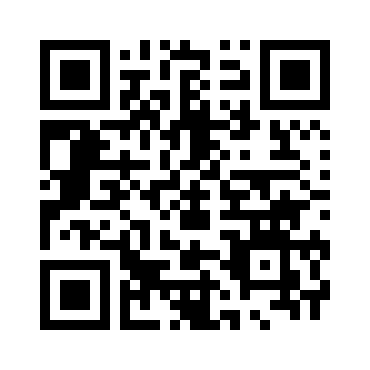

Encrypted data: 8vwxf58YJGRdUkbSRzndvrDE6xDYduvCDeTg6UjK44w=


In [17]:
# Generate the QR code
qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)
qr.add_data(enc_id)
qr.make(fit=True)

# Create and save the QR code image
img = qr.make_image(fill='black', back_color='white')
img.save("encrypted_qr_code.png")

# Optionally, show the image
img.show()

# The encrypted data (this is what is encoded in the QR code)
print("Encrypted data:", enc_id)

In [29]:
# Encrypt the message
key = os.urandom(32)  # 256-bit AES key
encrypted_data = encrypt_message("123", key)


In [32]:
encrypted_data

'Jq0lZZvDAbYQTteXQ3TlN5LvH+T8jQtusp3CI1f2vQA='

In [35]:
decrypt_message(encrypted_data, key)

'123'